## 5. Regression Difference in Difference Equations 

1st Regression: 

$price_{i} = β_{0} + β_{1} * $ Treatment_Period $+ ϵ_{i} $

- Treatment_Period: is a dummy variable that takes the value of 1 during the treatment period between 12-16 June 2024 and 0 otherwise between 5-9 of June 2024.
- Price: is the price for observation i in the time period.

2nd Regression: 

$price_{i} = β_{0} + β_{1} * $ Treatment_City $ + ϵ_{i} $

- Treatment_City: is a dummy that takes 1 if the city belongs to Barcelona and 0 if the city is Alicante.

3rd Regression:

$price_{i} = β_{0} + β_{1} * $ Treatment_Period $ + β_{2} * $ Treatment_city $ + β_{3} *$ (Treatment_Period * Treatment_City) $ + ϵ_{i} $

The coefficient of $β_{3}$ serves as the quantitative representation of the difference-in-differences (DiD) estimate. This parameter encapsulates the overall impact of the event on prices by examining the interplay between the "Treatment_Period" and "Treatment_City". Consequently, it enables the isolation and measurement of the distinct effect of the treatment when both factors are concurrently present.
<br>
<br>
In DiD analysis, it is vital to incorporate a second city/control city in order to establish a counterfactual. The control city addresses trends or factos equally influencing both treatment and control groups over time, providing a baseline for common influences. The interaction term "Treatment_Period * Treatment_City" captures the varying impact of the treatment across these groups. DiD discerns the treatment effect by comparing changes in the treatment city with those in the control city over the same period, reducing the influence of confounding variables and enhancing the robustness of estimating the event's impact on prices. 

## 6. Regression Models 

Imports

In [124]:
import json
import pandas as pd
import os
from bs4 import BeautifulSoup
import time
import requests
import statsmodels.api as sm
import numpy as np 
from googletrans import Translator
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
# Might need to pip install some libraries for translation
#!pip install langdetect 
#!pip install googletrans==4.0.0-rc1


In [125]:
#Barcelona Dataframes
Barcelona_festival = pd.read_csv("Barcelona_Festival.csv")
Barcelona_before = pd.read_csv("Barcelona_before.csv")

# Alicante Dataframes
Alicante_festival = pd.read_csv("Alicante_festival.csv")
Alicante_before = pd.read_csv("Alicante_before.csv")

Create Dummy Variables

In [126]:
# Dummmy Variables Barcelona during 12-16 June 
Barcelona_festival['Treatment_Period'] = 1
Barcelona_festival['Treatment_City'] = 1 

# Dummy Variable Barcelona during 5-9  June 
Barcelona_before['Treatment_Period'] = 0
Barcelona_before['Treatment_City'] = 1 

# Dummy Variable Alicante duing 12-16 June 
Alicante_festival['Treatment_Period'] = 1
Alicante_festival['Treatment_City'] = 0

# Dummy Variable Alicante during 5-9 June 
Alicante_before['Treatment_Period'] = 0
Alicante_before['Treatment_City'] = 0

Aggregate data into into a single dataframe across the two cities

In [127]:
df_total = pd.concat([Barcelona_festival, Barcelona_before, Alicante_festival ,Alicante_before], ignore_index=True)
df_total.head()

,Unnamed: 0,Hotel Name,Rating,Price,Hotel URL,Descriptions,Treatment_Period,Treatment_City
0,0,Room Mate Gerard,"8,8",€ 1.100,https://www.booking.com/hotel/es/room-mate-ger...,El Room Mate Gerard en Barcelona ofrece alojam...,1,1
1,1,Melia Barcelona Sarriá,"8,2",€ 1.378,https://www.booking.com/hotel/es/melia-barcelo...,"El Meliá Barcelona Sarriá cuenta con spa, gimn...",1,1
2,2,Catalonia Diagonal Centro,"8,4",€ 799,https://www.booking.com/hotel/es/catalonia-dia...,El Catalonia Diagonal Centro se encuentra en p...,1,1
3,3,Barcelona with rooms and lofts in front of the...,"7,0",€ 224,https://www.booking.com/hotel/es/casa-nou-barc...,Barcelona with rooms and lofts in front of the...,1,1
4,4,TWO Hotel Barcelona by Axel 4* Sup- Adults Only,"8,4",€ 964,https://www.booking.com/hotel/es/two-barcelona...,El TWO Hotel Barcelona by Axel está situado en...,1,1


Remove the Hotel URL column & the € from Price column

In [128]:
column_to_remove = ['Hotel URL']
df_total = df_total.drop(columns=column_to_remove)
df_total['Price'] = pd.to_numeric(df_total['Price'].str.replace('€', '').str.replace('.', ''), errors='coerce')

Check the average prices

In [129]:
# Check the mean of the prices
average_prices = df_total.groupby(['Treatment_City', 'Treatment_Period'])['Price'].mean()
print(average_prices)

Treatment_City  Treatment_Period
0               0                    634.067492
                1                    676.052511
1               0                   1081.593812
                1                   1480.578842
Name: Price, dtype: float64


Create the Interaction Term between the Treatment Period and Treatment City

In [130]:
df_total['Interaction_Period_City'] = df_total['Treatment_Period']  * df_total['Treatment_City']

Regression Models

The following results, for the OLS Regression for the treatment period, indicate a substantial and statistically significant difference in hotel prices between Barcelona and Alicante during the treatment period of the 12th-16th of June 2024. The coefficient for the variable "Treatment_Period" is 234.1026, associated with a p-value that is less than 0.05, suggesting that, on average, hotel prices in Barcelona are estimated to be 234.1026 euros higher than during the treatment period compared to the control period of 5th-9th of June 2024. 
<br>
<br>
However, it is crucial to acknowledge the limited explanatory power of the model, as reflected in the low R-squared value of 0.022. This implies that only a small fraction of variation in hotel prices is explained by the included variables. The presence of unaccounted factors may contribute to the observed price differences, emphasizing the need to caution in attributing the entire variation solely to the treatment period. 

In [131]:
# Regression for Treatment Period 
const_period= sm.add_constant(df_total['Treatment_Period'])
model_per = sm.OLS(df_total['Price'], const_period)
ols_period = model_per.fit()
print(ols_period.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     85.25
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           4.28e-20
Time:                        19:03:32   Log-Likelihood:                -30438.
No. Observations:                3769   AIC:                         6.088e+04
Df Residuals:                    3767   BIC:                         6.089e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              871.2020     17.898  

The following regression results, for the Treatment_City, reveal a substantial and statistically significant difference in hotel prices between our treatment city Barcelona, and our control city Alicante. The coefficient for the variable "Treatment_City" is 626.1809, associated with a p-value less than 0.05, indicating that, on average, hotel prices in Barcelona are estimated to be 626.1809 euros higher compared to Alicante. 
<br>
<br>
Once again, it is important to note the moderate explanatory power of the model, indicated by the R-squared value of 0.158. While this suggest that a noteworthy proportion of the variation in hotel prices is explained by the included variables, there are likely othe unaccounted factors influencing the observed price differences. 

In [132]:
# Regression for Treatment City
const_city= sm.add_constant(df_total['Treatment_City'])
model_city = sm.OLS(df_total['Price'], const_city)
ols_city = model_city.fit()
print(ols_city.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     705.3
Date:                Sun, 04 Feb 2024   Prob (F-statistic):          1.37e-142
Time:                        19:03:32   Log-Likelihood:                -30156.
No. Observations:                3769   AIC:                         6.032e+04
Df Residuals:                    3767   BIC:                         6.033e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            654.9054     17.193     38.

The following regression, of the interaction between "Treatment_Period" and "Treatment_City", indicate a substantial and statistically significant coefficient for the interaction term "Interaction_Period_City". The positive sign of this coefficient suggest a significant positive effect of the interaction between the treatment period and city of hotel prices. In simpler terms, we could say that the SONAR Festival in Barcelona during the specified period appears to positively influence hotel prices. 
<br>
<br>
Further understanding the results, the coefficient for "Treatment_Period" is 41.9850 but it is not stastically significant with a p-value of 0.213. This implies that the effect of the treatment period alone on hotel prices may not be statistically significant. On the other hand, the coefficient for the  "Treatment_City" appears to be 447.5263 and is statistically significant with a p-value lower than 0.001. This is indicating that being in Barcelona generally leads to higher hotel prices compared to Alicante. When looked at it together, the interaction term underscores the combined influence of the treatment period and treatment city on hotel prices, suggesting a positive and significant impact, that could possibly be attributed to the SONAR festival in Barcelona during the week of the 12th-16th of June 2024. 

In [133]:
# Regression for Treatment Interaction City and Period 
model_interaction = sm.OLS(df_total['Price'], sm.add_constant(df_total[['Treatment_Period', 'Treatment_City', 'Interaction_Period_City']]))
ols_interaction = model_interaction.fit()
print(ols_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     298.6
Date:                Sun, 04 Feb 2024   Prob (F-statistic):          6.67e-174
Time:                        19:03:32   Log-Likelihood:                -30078.
No. Observations:                3769   AIC:                         6.016e+04
Df Residuals:                    3765   BIC:                         6.019e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Partial Standard Regression Table

This table contains only the three regressions at the top. Section 7 contains the full table with the fourth column below. 

In [134]:
# Create a summary table
summary_table = summary_col([ols_period, ols_city, ols_interaction], stars=True)
print(summary_table)



                          Price I     Price II   Price III 
-----------------------------------------------------------
const                   871.2020*** 654.9054*** 634.0675***
                        (17.8976)   (17.1934)   (23.7309)  
Treatment_Period        234.1026***             41.9850    
                        (25.3548)               (33.6849)  
Treatment_City                      626.1809*** 447.5263***
                                    (23.5791)   (32.6007)  
Interaction_Period_City                         357.0000***
                                                (46.1949)  
R-squared               0.0221      0.1577      0.1922     
R-squared Adj.          0.0219      0.1575      0.1916     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## 7. Feature Extraction Controls

Check descriptions

To ensure cohesiveness, we will translate all the English descriptions in the dataset to Spanish using the translate_to_spanish() function. 

In [135]:
# Detect which language the description is in 
from langdetect import detect
df_total['Language'] = df_total['Descriptions'].apply(lambda x: detect(x) if type(x) == str else None)

# Count total descriptions in Spanish and in English 
english_count = df_total[df_total['Language'] == 'en'].shape[0]
spanish_count = df_total[df_total['Language'] == 'es'].shape[0]
print(f'Number of descriptions in English: {english_count}')
print(f'Number of descriptions in Spanish: {spanish_count}')

Number of descriptions in English: 17
Number of descriptions in Spanish: 3751


In [136]:
def translate_to_spanish(text):
    """
    Translates the descriptions from English to Spanish. 

    Parameters: 
        - text (str): The input description to be translated. 

    Returns: 
        - str: The translated description in Spanish. 
    """
    translator = Translator()
    translation = translator.translate(text, src='en', dest='es')
    return translation.text

english_descriptions = df_total[df_total['Language'] == 'en']['Descriptions']

# Translate English descriptions to Spanish
df_total.loc[df_total['Language'] == 'en', 'Descriptions'] = english_descriptions.apply(translate_to_spanish)

print(df_total)

      Unnamed: 0                                         Hotel Name Rating  \
0              0                                   Room Mate Gerard    8,8   
1              1                             Melia Barcelona Sarriá    8,2   
2              2                          Catalonia Diagonal Centro    8,4   
3              3  Barcelona with rooms and lofts in front of the...    7,0   
4              4    TWO Hotel Barcelona by Axel 4* Sup- Adults Only    8,4   
...          ...                                                ...    ...   
3764         884    Beautifully presented 5 bedroom villa with WIFI    NaN   
3765         885                                        Villa inaya    7,9   
3766         886                            Plaza Toros Apartamento    4,0   
3767         887  COZY ROOM GUAPO-ALICANTE Nearby The Beach and ...    6,2   
3768         888                                 Victoria Hospedaje    9,0   

      Price                                       Descriptions 

In [137]:
# Check if it worked (should all come out in Spanish now )
english_rows = df_total[df_total['Language'] == 'en']

# Display the rows where the language is English
print(english_rows)

      Unnamed: 0                         Hotel Name Rating  Price  \
150          150        Aparthotel Arai 4* Superior    9,0   1455   
160          160   Torre Melina, a Gran Meliá Hotel    NaN   1995   
288          288       Àmfores Boutique Guest House    8,1    926   
410          410             Sonder La Casa del Sol    7,9   1126   
461          461              TOC Hotel Las Ramblas    8,3   1354   
469          469   DO Plaça Reial powered by Sonder    8,4   1980   
481          481               Ant Hostel Barcelona    7,0    993   
544          544          Twentytu Hostel Barcelona    7,7   1993   
1222         220       Àmfores Boutique Guest House    8,1    766   
1289         287        Aparthotel Arai 4* Superior    9,0   1489   
1305         303   Torre Melina, a Gran Meliá Hotel    NaN   2215   
1334         332          Twentytu Hostel Barcelona    7,7   2353   
1575         573             Sonder La Casa del Sol    7,9   1145   
1621         619   DO Plaça Reial 

We have chosen to use amenities and location-related words to add as controls for the model. We use an TFIDF matrix to find those words that are both unique and related to amenities and location. We remove stopwords and perform n-gramming before printing the list.

In [138]:
df_total['Description'] = df_total['Descriptions'].fillna('')
df_total['Descriptions'] = df_total['Descriptions'].astype(str)

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

nltk.download('stopwords')

spanish_stopwords = stopwords.words('spanish')

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=spanish_stopwords, ngram_range=(1,1))

# Fit and transform the processed descriptions to a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df_total['Descriptions'])

# Get the feature names
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Sum the TF-IDF scores for each term across all documents
sum_tfidf = tfidf_matrix.sum(axis=0)

# Sort indices in descending order of TF-IDF scores
sorted_indices = np.argsort(sum_tfidf).flatten()[::-1]

# Get the top 500 words and their scores
top_500_words = feature_names[sorted_indices[:500]]
top_500_scores = np.array(sum_tfidf)[0, sorted_indices[:500]]

# Print the top 100 words with their TF-IDF scores
for word, score in zip(top_500_words, top_500_scores):
    print(f"{word}")

# Ensure that the data extracted is 1-dimensional
top_500_words = feature_names[sorted_indices[:500]].flatten()
top_500_scores = np.array(sum_tfidf)[0, sorted_indices[:500]].flatten()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nataliabeltran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['bitérmica' 'dificultades' 'hectáreas' ... 'alojamiento' 'km' 'alicante']


In [139]:
top_500_words

array(['bitérmica', 'dificultades', 'hectáreas', ..., 'alojamiento', 'km',
       'alicante'], dtype=object)

The plot below implies that none of the words is much more unique than the other top words. Instead, the plot is quite uniform. This is good as it means we get a nice subset of words related to amenity and location that are all informative to a similar extent.

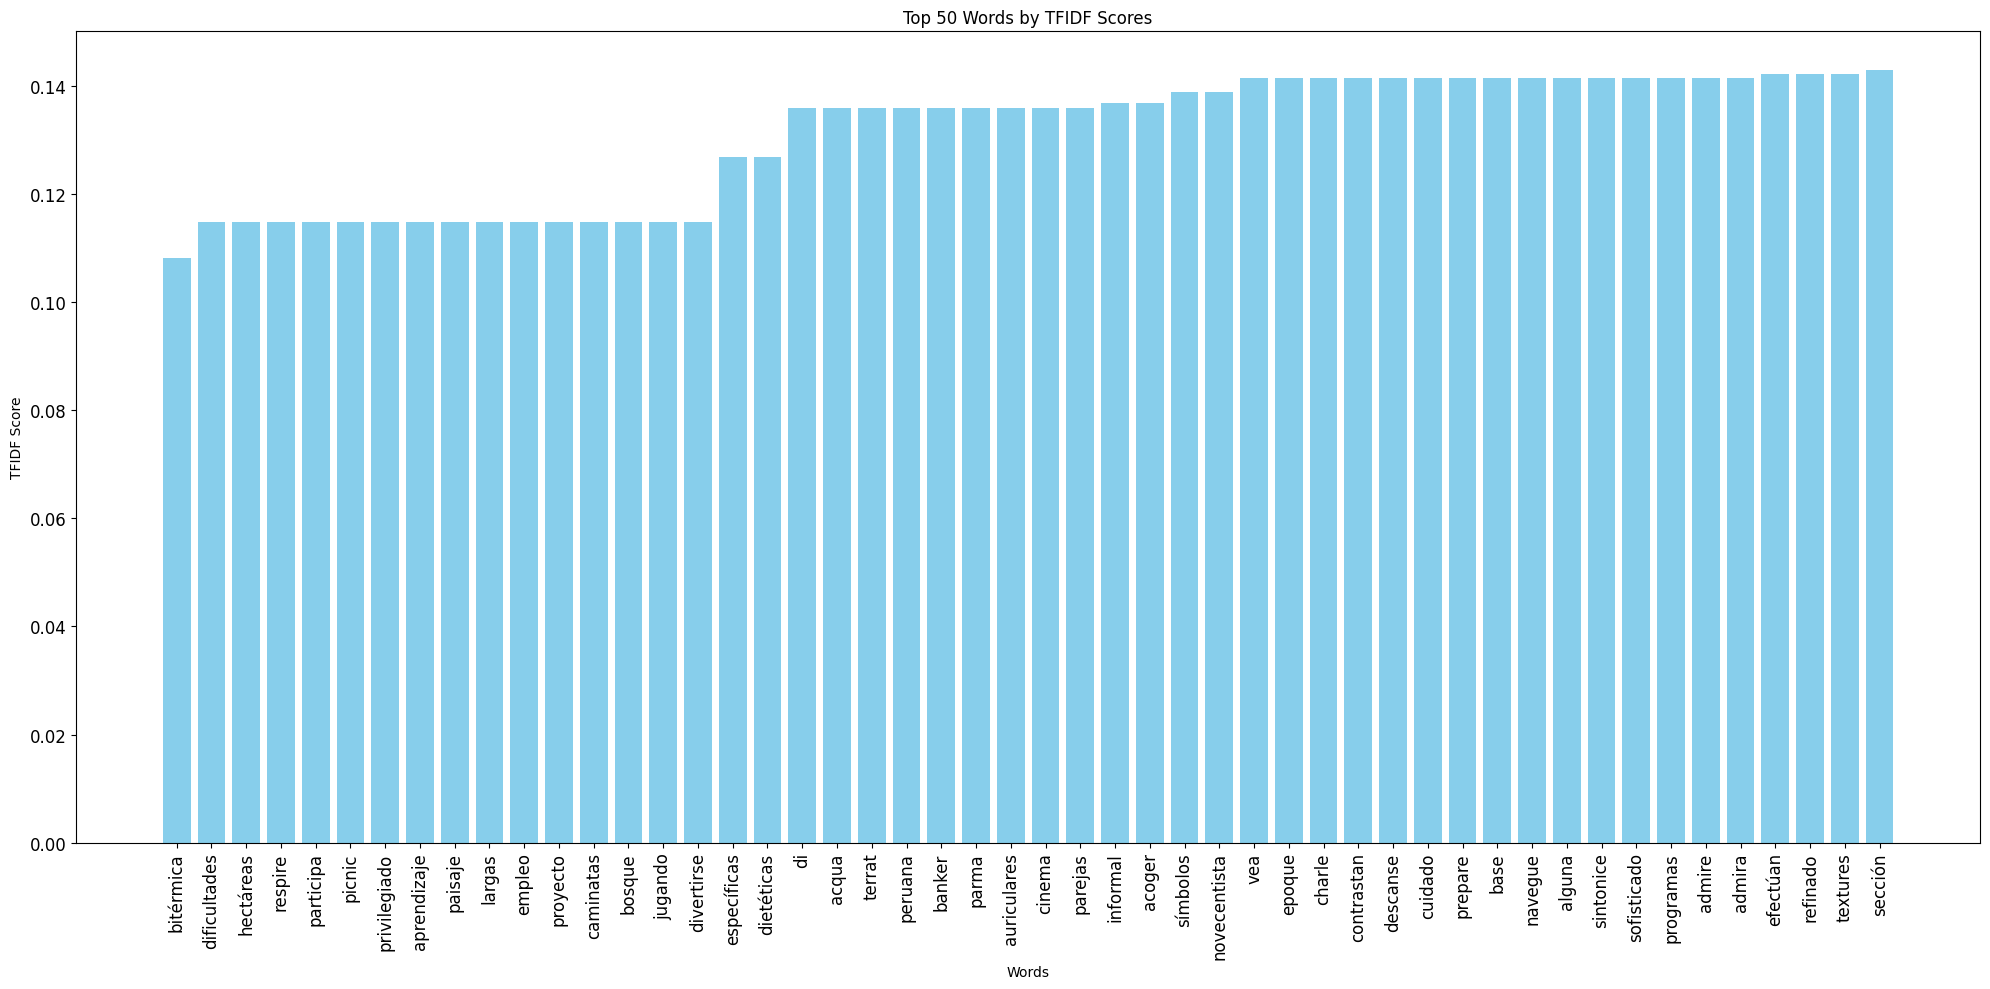

In [140]:
#Now we plot the top words in the TFIDF matrix by their score
top_df = pd.DataFrame({'word': top_500_words, 'tfidf score': top_500_scores})

top_500_df = top_df[:500]

top_50_df = top_500_df[:50]

# Proceed to plot
plt.figure(figsize=(20, 10))  # Adjust figure size for better visibility
plt.bar(top_50_df['word'], top_50_df['tfidf score'], color='skyblue')

plt.ylabel('TFIDF Score')
plt.xlabel('Words')
plt.title('Top 50 Words by TFIDF Scores')

# Rotate the x labels to fit them better and set font size to small
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Adjust layout
plt.show()

In [141]:
top_500_df_words = top_500_df['word']
top_500_df_words.to_csv('words_1')

top_500_df

,word,tfidf score
0,bitérmica,0.108126
1,dificultades,0.114750
2,hectáreas,0.114750
3,respire,0.114750
4,participa,0.114750
...,...,...
495,1892,0.252923
496,besalú,0.253433
497,82,0.253433
498,tecnológicas,0.253758


Now we pick out the words from the top 500 that relate to amenities and location. We have been quite generous with inclusion criteria as we don't want too much researcher judgement to interfere with the results.

In [142]:
# Selected words from the top 500 ITFDF scores related to amenities and location:
amenities_itfdf = [
    "bitérmica","auriculares","acqua","cinema","fumadores","pizzas","cocinilla","cabina","supervisados",
    "terapeutas","escúteres","cancha","lobby","gel","champú","aparcamientos","armarios","limpias",
    "toallero","colchoneta","secadores","kitchen","aseos","intolerancias","equipajes","cocheras",
    "garaje","infinito","bolera","piscine",
]

location_itfdf = [
     "bosque","paisaje","privilegiado","circundantes","proximidad","naturaleza","montseny",
    "berceloneta","pirineos"
]

Now we find the top words across all documents. While these words are less informative about a single document than the TFIDF matrix because they are used widely across the dataset, their absence may also be a useful indicator.

In [143]:
# Step 1: Initialize CountVectorizer
# We don't set max_features=500 here because we first want to create the full document frequency matrix
vectorizer = CountVectorizer(analyzer='word', stop_words=spanish_stopwords, ngram_range=(1,1))

# Step 2: Fit the vectorizer to the 'Descriptions' and transform the text to a document frequency matrix
X = vectorizer.fit_transform(df_total['Descriptions'])

# Step 3: Sum the occurrence of each word across all documents to find the most used words
word_counts = X.sum(axis=0)
words_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

# Step 4: Sort the words by their frequency
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

pd.DataFrame(words_freq)

# Step 5: Extract the top 500 words
top_500_words_docfreq = words_freq[:500]

# Convert the list of tuples into two lists: one for words and another for their corresponding frequencies
words_freq_df = pd.DataFrame(words_freq)

# Now `top_500_words_list` contains the top 500 most used words in the 'Descriptions' column
print(top_500_words_docfreq)

[('km', 7917), ('alojamiento', 6512), ('alicante', 6261), ('aeropuerto', 5503), ('ofrece', 4521), ('apartamento', 4428), ('barcelona', 4131), ('pie', 3735), ('aire', 3387), ('wifi', 3089), ('acondicionado', 2958), ('estación', 2865), ('cocina', 2749), ('tv', 2577), ('playa', 2503), ('minutos', 2442), ('gratis', 2390), ('baño', 2286), ('encuentra', 2265), ('habitaciones', 2215), ('hotel', 2144), ('cerca', 1955), ('metros', 1889), ('pantalla', 1819), ('plana', 1806), ('cama', 1763), ('nevera', 1760), ('vistas', 1726), ('terraza', 1720), ('interés', 1698), ('zona', 1691), ('min', 1675), ('tren', 1663), ('ropa', 1662), ('cercano', 1647), ('equipada', 1634), ('toallas', 1623), ('centro', 1588), ('privado', 1578), ('ducha', 1506), ('puntos', 1500), ('elche', 1490), ('miguel', 1489), ('hernández', 1488), ('metro', 1479), ('cuenta', 1407), ('plaza', 1393), ('museo', 1336), ('dispone', 1323), ('san', 1310), ('gratuita', 1307), ('ciudad', 1304), ('postiguet', 1278), ('dormitorios', 1254), ('tota

The plot below shows the words are distributed according to a Zipfian distribution as we would expect with natural language. Some words are really uninformative, like 'km' which is mentioned in nearly every document. However, most of the words are only mentioned in < 2000 documents, so are actually quite informative for subsetting the hotels.

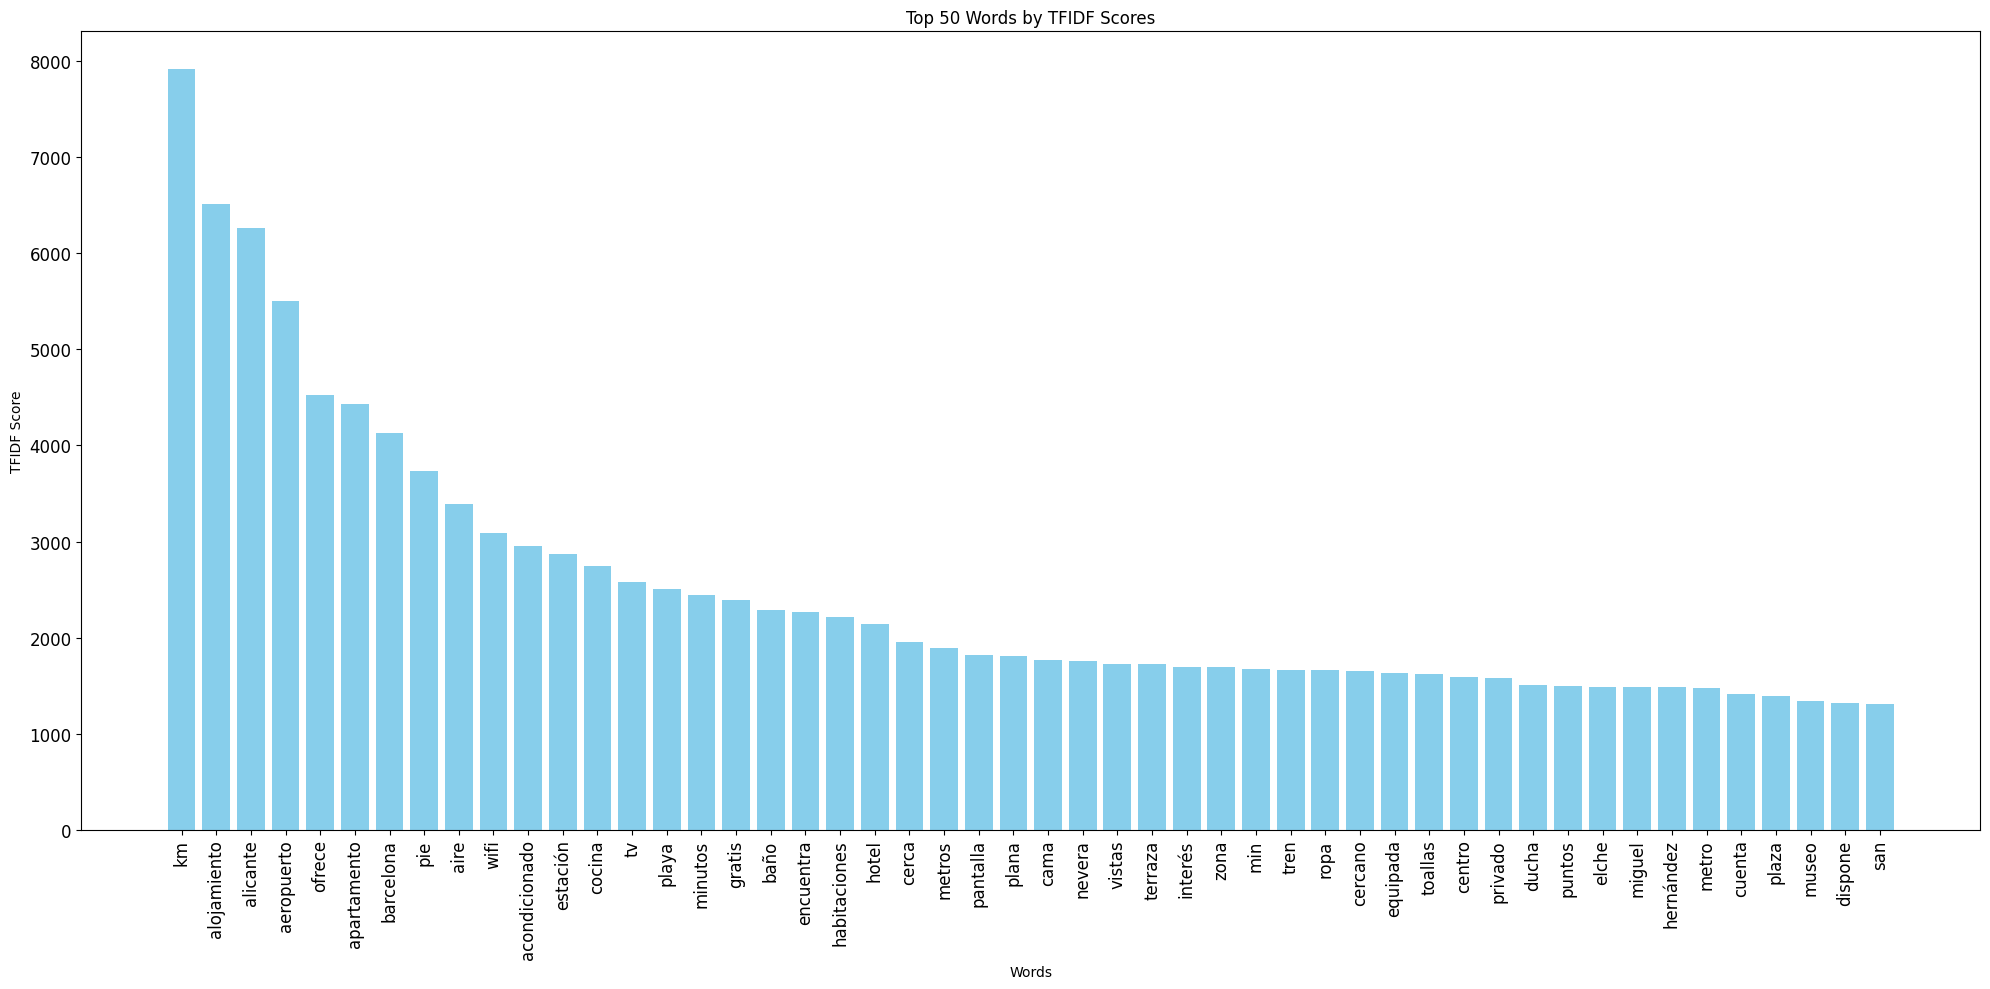

In [144]:
top_50_freq_df = words_freq_df[:50]

# Proceed to plot
plt.figure(figsize=(20, 10))  # Adjust figure size for better visibility
plt.bar(top_50_freq_df[0], top_50_freq_df[1], color='skyblue')

plt.ylabel('TFIDF Score')
plt.xlabel('Words')
plt.title('Top 50 Words by TFIDF Scores')

# Rotate the x labels to fit them better and set font size to small
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Adjust layout
plt.show()

In [145]:
top_500_words_freqdf = pd.DataFrame(top_500_words_docfreq)
words_frequencies = top_500_words_freqdf[0]
words_frequencies.to_csv('wordiewordsss')

In [146]:
amenities_freq = amenities_related_words = [
    "wifi","aire acondicionado","cocina","tv","playa","gratis","baño", "habitaciones",
    "pantalla plana","cama","nevera","vistas","terraza","toallas","ducha","museo",
    "piscina","golf","recepción","microondas","lavavajillas","horno","restaurante",
    "desayuno","comedor","parking","gimnasio","spa","sauna","cafetera","secador pelo",
    "jardín","servicio","lavadora","sala","satélite","bar","minibar","cafetería",
    "cable","bicicletas","hidromasaje","solárium","tostadora",
]


location_freq = location_related_words = [
    "alicante","aeropuerto","barcelona","playa","estación","centro","elche",
    "ciudad","museo","sagrada","familia","catedral","parque","mercado","eixample",
    "montjuïc","puerto","palacio","gótico","ramblas","explanada","gracia","passeig",
    "pedrera","batlló","diagonal","casa","plaza","san","sants","camp","nou","parc",
    "güell","postiguet","terra","mítica","boquería","plaça","catalunya","gràcia",
    "barceloneta","port","vila","olímpica","llevant","poblenou","somorrostro",
    "montjuic","barri","gòtic","born","raval",
]


amenities = amenities_itfdf + amenities_freq
location = location_itfdf + location_freq

Now we count the number of occurances of the words in 'amenities' and the words in 'location' in each hotel's description and add them to two new columns.

In [147]:
df_total['amenities'] = 0
df_total['location'] = 0

def amenities_count(description):
    # Lowercase the description to improve matching
    description_lower = description.lower()
    # Sum the occurrences of each amenity word in the description
    return sum(description_lower.count(amenity.lower()) for amenity in amenities)

# Apply the corrected function to each row in the 'Descriptions' column
df_total['amenities'] = df_total['Descriptions'].apply(amenities_count)

def location_count(description):
    # Lowercase the description to improve matching
    description_lower = description.lower()
    # Sum the occurrences of each amenity word in the description
    return sum(description_lower.count(location.lower()) for location in location)

# Apply the corrected function to each row in the 'Descriptions' column
df_total['location'] = df_total['Descriptions'].apply(location_count)
df_total.head()

,Unnamed: 0,Hotel Name,Rating,Price,Descriptions,Treatment_Period,Treatment_City,Interaction_Period_City,Language,Description,amenities,location
0,0,Room Mate Gerard,"8,8",1100,El Room Mate Gerard en Barcelona ofrece alojam...,1,1,1,es,El Room Mate Gerard en Barcelona ofrece alojam...,16,10
1,1,Melia Barcelona Sarriá,"8,2",1378,"El Meliá Barcelona Sarriá cuenta con spa, gimn...",1,1,1,es,"El Meliá Barcelona Sarriá cuenta con spa, gimn...",18,13
2,2,Catalonia Diagonal Centro,"8,4",799,El Catalonia Diagonal Centro se encuentra en p...,1,1,1,es,El Catalonia Diagonal Centro se encuentra en p...,15,20
3,3,Barcelona with rooms and lofts in front of the...,"7,0",224,Barcelona with rooms and lofts in front of the...,1,1,1,es,Barcelona with rooms and lofts in front of the...,5,14
4,4,TWO Hotel Barcelona by Axel 4* Sup- Adults Only,"8,4",964,El TWO Hotel Barcelona by Axel está situado en...,1,1,1,es,El TWO Hotel Barcelona by Axel está situado en...,29,14


Now we have to adjust the ratings and price columns. The ratings have commas for decimal points, and the prices have euro signs and points separating thousands from hundreds digits. We also impute missing ratings using KNN.

In [148]:
#First we need to convert the comma to a dot:
df_total['Rating'] = df_total['Rating'].str.replace(',', '.').astype(float)

#And convert price to a float:
df_total['Price'] = df_total['Price'].astype(float)

#Now we impute NAs:
from sklearn.impute import KNNImputer
data_for_imputation = df_total[['Rating']]
imputer = KNNImputer(n_neighbors=10)
data_imputed = imputer.fit_transform(data_for_imputation)
df_total['Rating'] = data_imputed[:, 0]
df_total.head()

,Unnamed: 0,Hotel Name,Rating,Price,Descriptions,Treatment_Period,Treatment_City,Interaction_Period_City,Language,Description,amenities,location
0,0,Room Mate Gerard,8.8,1100.0,El Room Mate Gerard en Barcelona ofrece alojam...,1,1,1,es,El Room Mate Gerard en Barcelona ofrece alojam...,16,10
1,1,Melia Barcelona Sarriá,8.2,1378.0,"El Meliá Barcelona Sarriá cuenta con spa, gimn...",1,1,1,es,"El Meliá Barcelona Sarriá cuenta con spa, gimn...",18,13
2,2,Catalonia Diagonal Centro,8.4,799.0,El Catalonia Diagonal Centro se encuentra en p...,1,1,1,es,El Catalonia Diagonal Centro se encuentra en p...,15,20
3,3,Barcelona with rooms and lofts in front of the...,7.0,224.0,Barcelona with rooms and lofts in front of the...,1,1,1,es,Barcelona with rooms and lofts in front of the...,5,14
4,4,TWO Hotel Barcelona by Axel 4* Sup- Adults Only,8.4,964.0,El TWO Hotel Barcelona by Axel está situado en...,1,1,1,es,El TWO Hotel Barcelona by Axel está situado en...,29,14


Because we are going to control for rating as well in the regression, we wanted to check how well the text controls correlate with rating to ensure we are not controlling for the same thing twice. We find that there is a very weak, but statistically significant correlation between amenities with rating. This is to be expected given many more factors make up rating than just amenities, but also means we are likely controlling more information by including the two textual controls than if we just controlled by rating.

In [149]:
#how do these words correlate with ratings?
df_total['Rating'] = pd.to_numeric(df_total['Rating'])

# Define the independent variables (X) and the dependent variable (y)
X = df_total[['amenities', 'location']]  # Independent variables
y = df_total['Rating']  

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     131.2
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           8.31e-56
Time:                        19:04:11   Log-Likelihood:                -5275.0
No. Observations:                3769   AIC:                         1.056e+04
Df Residuals:                    3766   BIC:                         1.057e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3289      0.077     94.778      0.000       7.177       7.480
amenities      0.0585      0.004     16.122      0.000       0.051       0.066
location       0.0010      0.004      0.242      0.809      -0.007       0.009
==============================================================================
Omnibus:                     1594.018   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12249.378
Skew:                          -1.831   Prob(JB):                         0.00
Kurtosis:                      11.037   Cond. No.                         103.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this final regression model, we aimed to enhance the analysis by incorporating relevant terms from the document term matrix that are correlated with hotel pricing. The coefficient for 'Treatment_Interaction' is 350.6808, and it remains highly statistically significant (p-value < 0.001), suggesting that the event occurring in Barcelona during the specified time period indeed has a positive influence on hotel pricing. This supports the notion that the SONAR festival in Barcelona contributes to an increase in hotel prices.
<br>
<br>
Furthermore, we explored the impact of other factors on hotel prices. The coefficients for 'Rating,' 'Amenities' and 'Location' provide insights into how these descriptive elements in hotel listings are associated with pricing. It's worth noting that the coefficient for 'Location' is statistically significant (p-value = 0.034), indicating that the geographical location has a discernible influence on hotel prices.
<br>
<br>
There is an interaction effect between the city and period, which means one of the cities may exhibit a price change during the treatment week but the other does not. To test this, we run the regression separately for each city.

In [150]:
df_total['Treatment_Interaction'] = df_total['Treatment_City'] * df_total['Treatment_Period']

import statsmodels.api as sm

X = df_total[['Treatment_Period', 'Treatment_City', 'Treatment_Interaction', 'Rating', 'amenities', 'location']]
X = sm.add_constant(X)

y = df_total['Price']  # Making sure 'Price' is of float type for the regression

# Running the regression
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     165.1
Date:                Sun, 04 Feb 2024   Prob (F-statistic):          9.65e-187
Time:                        19:04:11   Log-Likelihood:                -30039.
No. Observations:                3769   AIC:                         6.009e+04
Df Residuals:                    3762   BIC:                         6.014e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    43.82

#### Difference in Differences Plot

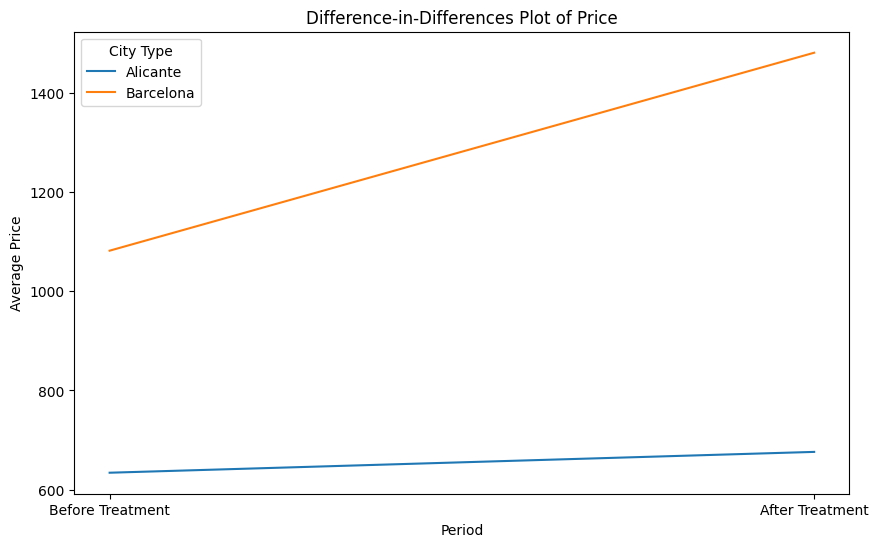

In [151]:
# Calculate the averages again if needed
grouped = df_total.groupby(['Treatment_City', 'Treatment_Period'])['Price'].mean().unstack()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
city_names = {0: 'Alicante', 1: 'Barcelona'}  

# Plot each group with a loop to manually control colors, markers, etc.
for city_code, group_data in grouped.iterrows():
    group_data.plot(ax=ax, label=city_names.get(city_code, f'City {city_code}'))

ax.set_title('Difference-in-Differences Plot of Price')
ax.set_ylabel('Average Price')
ax.set_xlabel('Period')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Before Treatment', 'After Treatment'], rotation=0)

# Add legend
ax.legend(title="City Type")

plt.show()

#### Additional insight with regressions separately for Barcelona and Alicante

Treatment period is indeed significant for Barcelona hotel prices. The price is significantly higher during the treatment period when the event occurs. The location control was also significant, implying that the price change is not constant in hotels across the city, and the rating control is significant, implying the change in price is greater at either higher or lower end hotels.  

In [152]:
data_barcelona = df_total[df_total['Treatment_City'] == 1]
data_alicante = df_total[df_total['Treatment_City'] == 0]

#Running the regression again for Barcelona:
X_barcelona = data_barcelona[['Treatment_Period', 'Rating', 'amenities', 'location']]
X_barcelona = sm.add_constant(X_barcelona)

y_barcelona = data_barcelona['Price']

model = sm.OLS(y_barcelona, X_barcelona).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     36.44
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           1.95e-29
Time:                        19:04:12   Log-Likelihood:                -16371.
No. Observations:                2004   AIC:                         3.275e+04
Df Residuals:                    1999   BIC:                         3.278e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              264.9265    180.043  

The treatment effect is also significant for Alicante, albeit with a far smaller effect size. It is odd that the treatment period was not significant when averaged across the two cities, but this can happen, especially when the sample sizes are dissimilar. There may be a factor influencing hotel prices across Spain (or a region of it), and then another factor influencing just Barcelona hotel prices. There are likely many factors that influence hotel prices, especially in a large city like Barcelona, so this result is reasonable.

In [153]:
#Running the regression again for Alicante:
X_alicante = data_alicante[['Treatment_Period', 'Rating', 'amenities', 'location']]
X_alicante = sm.add_constant(X_alicante)

y_alicante = data_alicante['Price']

model = sm.OLS(y_alicante, X_alicante).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     34.47
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           9.77e-28
Time:                        19:04:12   Log-Likelihood:                -13313.
No. Observations:                1765   AIC:                         2.664e+04
Df Residuals:                    1760   BIC:                         2.666e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              378.1986    101.745  

### Standard Regression Table 

Complete table for the four columns

In [154]:
# Create a summary table
summary_table = summary_col([ols_period, ols_city, ols_interaction, model], stars=True)
print(summary_table)


                          Price I     Price II   Price III   Price IIII
-----------------------------------------------------------------------
const                   871.2020*** 654.9054*** 634.0675*** 378.1986***
                        (17.8976)   (17.1934)   (23.7309)   (101.7451) 
Treatment_Period        234.1026***             41.9850     48.7209**  
                        (25.3548)               (33.6849)   (21.7825)  
Treatment_City                      626.1809*** 447.5263***            
                                    (23.5791)   (32.6007)              
Interaction_Period_City                         357.0000***            
                                                (46.1949)              
Rating                                                      -3.9950    
                                                            (10.4718)  
amenities                                                   31.1385*** 
                                                            (2.

## 8. Hotel Fixed Effect Regression 

Fixed effects would mean controlling for all unobserved features of the hotels that are constant over time. This would counteract any heterogeneity between hotels that could moderate the effect of the treatment on prices. The hotels become many observations of the same variable, varying only by city and time period (the independent variables of interest), so we can be sure that any observed effect is explained completely by these variables. By controlling for rating, amenities, and location, we have reduced at least a portion of the heterogeneity between hotels, so the significant effect we observed is unlikely to be affected by the quality of the hotel or its location.